# NIN

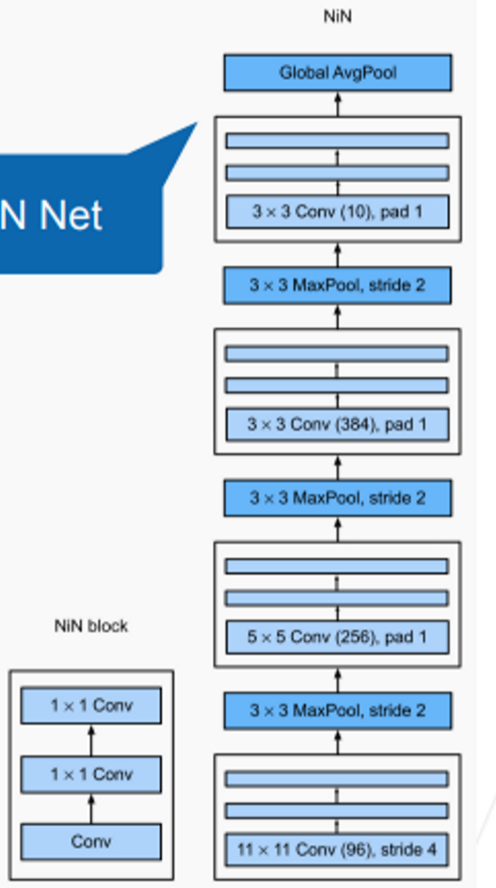

## NIN块

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

#需要指定每个nin块的第一层卷积的输入通道，输出通道，kernel_size,stride，padding
#nin块中输出通道数不改变
#stride缺省默认1，padding缺省默认0
#后面两层卷积都是1*1的卷积
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), 
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU())

## NIN网络

In [5]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2), nn.Dropout(0.5),
    #最后一个nin_block会把通道数降为10，这是类别数
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    #将窗口形状自动设置成输入的高和宽
    #把高宽都变成1
    #不管你的通道多大，对每个通道都把平均值拿出来
    #替代最后的全连接层的那个输出层，最后的那个nn.Linear(in_channels,10)
    nn.AdaptiveAvgPool2d((1, 1)),
    #出来是一个4Dbatch,channel,1,1
    #展平之后是（batch，10）,直接做softmax,这个没有放到网络上面，是放在了training上面
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

## 查看网络的输出形状

In [6]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## 训练模型

loss 0.350, train acc 0.871, test acc 0.872
1726.1 examples/sec on cuda:0


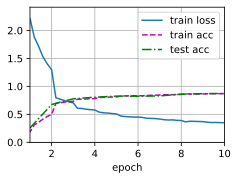

In [7]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 答疑

- 不管batchsize多大，权重（模型的大小）和梯度都是要存的，剩下的就与batchsize成线性关系。
- pytorch中的交叉熵损失函数已经包含了softmax计算，所以直接输入原始的线性结果就行，出来的就是概率
- 全局平均池化把模型复杂度降低了，提高了泛化性，精度更好，坏处是收敛变慢。
- AlexNet和VGG训练的快/收敛的快，是因为两个4096的层，太容易去拟合数据。绝大多情况多训练几个小时没关系，精度好才重要。
- 在GPU作预测，作完预测要copy回CPU
- pytorch会自动给一个初始化，在代码里也有手动初始化权重，为了得到可控性。